In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.executing_eagerly()

True

In [2]:
# Data
x = 0.66+tf.random.normal([5000])
# Two variables
mu = tf.Variable([0.]) # Mean of the distribution
sigma = tf.Variable([3.]) # Standard deviation of the distribution

# The model is a probability distribution
model = tfd.Normal(loc=mu, scale=sigma)

In [3]:
def loss(model, data):
    total_log_prob = -tf.reduce_mean(model.log_prob(data))
    return total_log_prob
    

def grad(model, inputs):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [4]:
optimizer = tf.optimizers.Adam(0.01)

opt_list = []
prob_values = []
value_range = tf.linspace(-5.,5.,100)

for i in range(300):
    loss_value, grads = grad(model, x)
    optimizer.apply_gradients(zip(grads, [mu, sigma]))
    if i % 10 == 0:
        print("Step: {}, initial loss: {}, mu: {}, sigma: {}".format(
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            mu.numpy(), 
            sigma.numpy()))
        opt_list.append((
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            mu.numpy()[0], 
            sigma.numpy()[0]))
        prob_values.append(model.prob(value_range))

Step: 1, initial loss: 2.0962188243865967, mu: [0.00999956], sigma: [2.99]
Step: 11, initial loss: 2.0606961250305176, mu: [0.10957113], sigma: [2.8898435]
Step: 21, initial loss: 2.024738311767578, mu: [0.20697378], sigma: [2.7889993]
Step: 31, initial loss: 1.9883517026901245, mu: [0.29997817], sigma: [2.6870258]
Step: 41, initial loss: 1.9515280723571777, mu: [0.3862035], sigma: [2.5836723]
Step: 51, initial loss: 1.9142296314239502, mu: [0.46324503], sigma: [2.4788554]
Step: 61, initial loss: 1.8763669729232788, mu: [0.5288099], sigma: [2.372604]
Step: 71, initial loss: 1.8377958536148071, mu: [0.5809822], sigma: [2.2650142]
Step: 81, initial loss: 1.7983431816101074, mu: [0.61866796], sigma: [2.1562216]
Step: 91, initial loss: 1.7578620910644531, mu: [0.6421198], sigma: [2.0463867]
Step: 101, initial loss: 1.716322422027588, mu: [0.65326977], sigma: [1.9357088]
Step: 111, initial loss: 1.6738851070404053, mu: [0.6555719], sigma: [1.8244597]
Step: 121, initial loss: 1.6309512853622

Plotting an animation of updates in the probability distribution fitted by the model

In [49]:
def init_fig(f, ax, artists):
    
    # Set axis and plot titles
    ax.set_title("Fitting data with Maximum Likelihood", fontsize=20)
    ax.set_xlabel("Values of the distribution", fontsize=14)
    ax.set_ylabel(r"$p(D|\theta)$", fontsize=14)
    
    ax.set_xlim(-5., 5.)
    ax.set_ylim(0.,0.8)
    plt.hist(x, bins=50, density =True);
    
    return artists

def frame_iter():
    for i in range(len(prob_values)):
        yield (opt_list[i][0], prob_values[i])
        
def update_artists(frames, artists):
    s, p = frames
    artists.prob.set_data(value_range, p)
    artists.step.set_text("Step " + str(s))

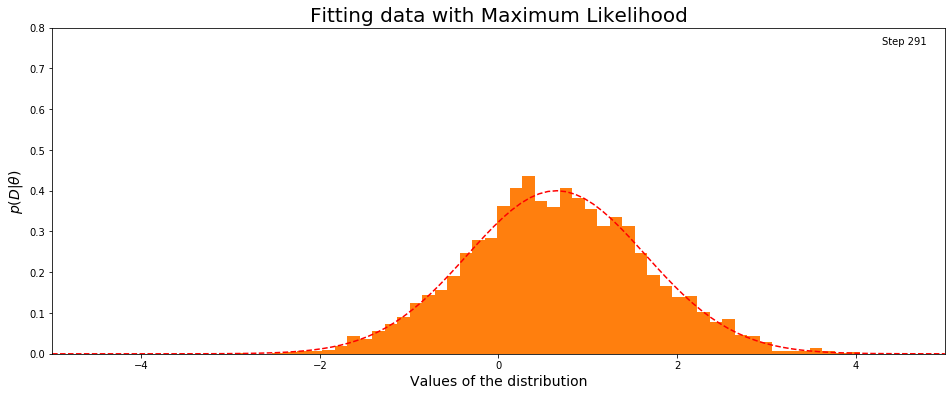

In [50]:
from functools import partial
from collections import namedtuple

f, ax = plt.subplots(figsize=(16,6))
Artists = namedtuple("Artists",("prob","step"))
artists = Artists(plt.plot([], [], "r--",animated=True)[0], 
                  ax.text(x=4.3, y = 0.76, s=""))

init = partial(init_fig, f=f, ax=ax, artists=artists)
update = partial(update_artists, artists=artists)

ani = animation.FuncAnimation(fig=f, 
                              func=update, 
                              frames = frame_iter,
                              init_func = init)

ani.save(
  filename='myvideo.mp4'
)

Now let's plot the learning curves:

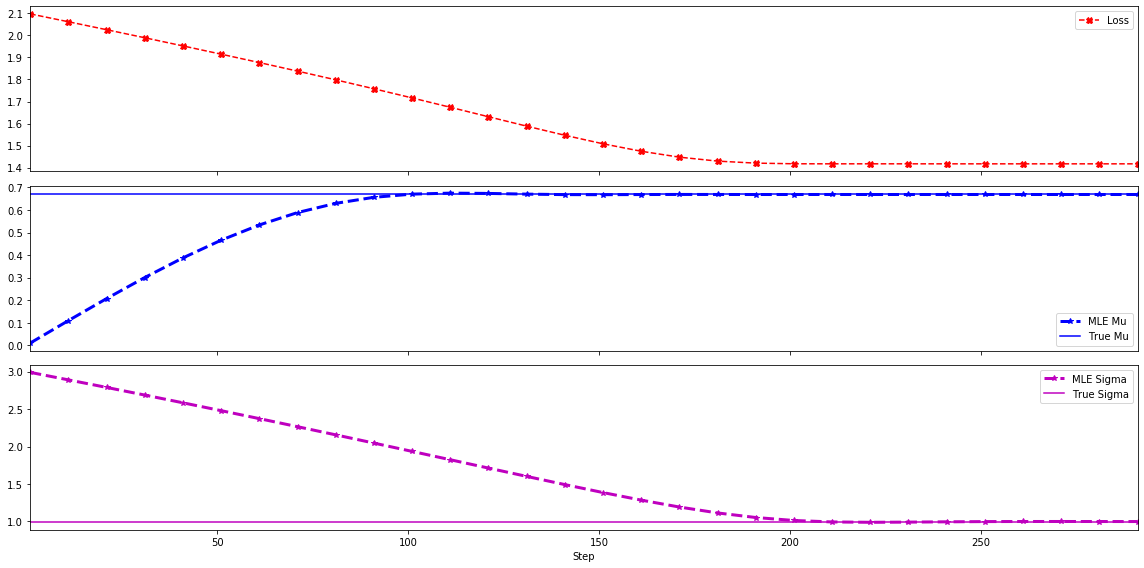

In [78]:
import pandas as pd

mle_df = pd.DataFrame(opt_list, columns=['Step','Loss','Mu','Sigma'])

f, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 8))
mle_df.plot(x = "Step", y='Loss',style="r--X" ,ax=ax[0])
mle_df.plot(x = "Step", y="Mu", style="b--*",linewidth=3,ax=ax[1])
ax[1].axhline(tf.math.reduce_mean(x).numpy(), color="b")
ax[1].legend(["MLE Mu", "True Mu"])
mle_df.plot(x = "Step", y="Sigma", style="m--*",linewidth=3,ax=ax[2])
ax[2].axhline(tf.math.reduce_std(x).numpy(), color="m")
ax[2].legend(["MLE Sigma", "True Sigma"])
plt.tight_layout()